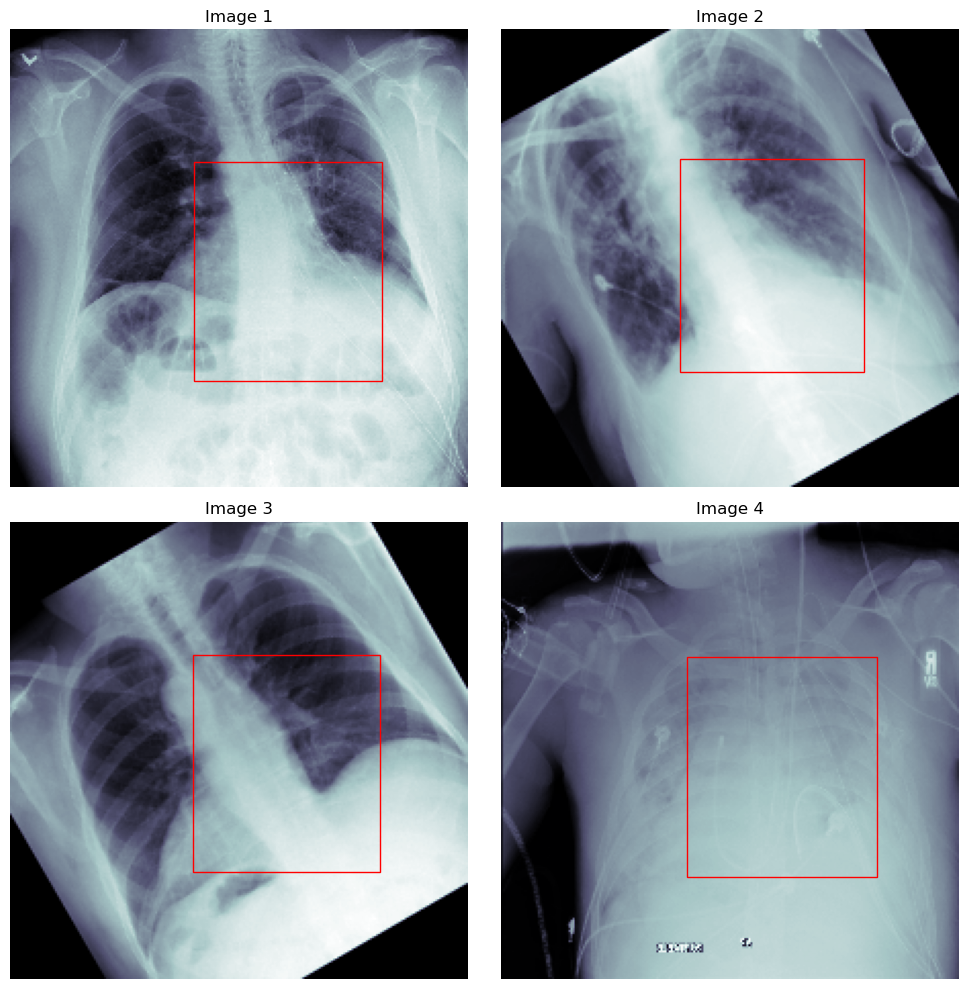

In [5]:
import torch
import torchvision
import pytorch_lightning as pl
import cv2
import torchvision.utils
import os
import random
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from torchvision import transforms
from imgaug.augmentables.bbs import BoundingBox

class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



# Custom Dataset Class for Cardiac Images
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, labels_csv_path, patient_file, root_dir, augmentations):
        self.labels_df = pd.read_csv(labels_csv_path)  # Load labels CSV
        self.patient_ids = np.load(patient_file)        # Load patient IDs
        self.root_dir = Path(root_dir)                  # Path to root directory
        self.augment = augmentations                    # Augmentation pipeline
    
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, index):
        label_data = self.labels_df.iloc[index]
        bbox = [label_data["x0"].item(), label_data["y0"].item(),
                label_data["x0"].item() + label_data["w"].item(),
                label_data["y0"].item() + label_data["h"].item()]

        # Load the image for the current patient
        patient_id = self.patient_ids[index]
        img_path = self.root_dir / f"{patient_id}.npy"
        image = np.load(img_path).astype(np.float32)

        # Apply augmentations if specified
        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 1000000, (1,)).item()
            image, augmented_bbox = self.augment(image=image, bounding_boxes=bb)
            bbox = [augmented_bbox[0][0], augmented_bbox[0][1], augmented_bbox[1][0], augmented_bbox[1][1]]

        # Normalize image
        image = (image - 0.494) / 0.252  # Normalize based on pre-trained stats
        image_tensor = torch.tensor(image).unsqueeze(0)  # Add channel dimension
        bbox_tensor = torch.tensor(bbox)                # Convert bbox to tensor

        return image_tensor, bbox_tensor


# Load the pre-trained model (resolving deprecation warning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "C:/Users/muaaz/Downloads/rsna_pneumonia-detection-challenge/rsna-pneumonia-detection-challenge/logs_cd/lightning_logs/version_0/checkpoints/epoch=99-step=5000.ckpt"
model = CardiacDetectionModel.load_from_checkpoint(model_path)
model.to(device)

# Function to load and preprocess DICOM images
folder_path = Path("DatasetForEvaluation")
dicom_images = []

# Load the first 20 DICOM images
for idx, dicom_file in enumerate(folder_path.glob("*.dcm")):
    if idx >= 20:
        break
    dicom_data = pydicom.dcmread(dicom_file)
    dicom_array = dicom_data.pixel_array
    dicom_resized = cv2.resize(dicom_array, (224, 224))  # Resize images to 224x224
    dicom_images.append(dicom_resized)

# Randomly select 4 images for augmentation and prediction
selected_images = random.sample(dicom_images, 4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

with torch.no_grad():
    for idx, img in enumerate(selected_images):
        # Apply random augmentations
        if random.random() > 0.5:
            img = cv2.flip(img, 1)  # Horizontal flip
        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            h, w = img.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            img = cv2.warpAffine(img, rotation_matrix, (w, h))

        # Convert image to tensor and add batch dimension
        image_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device).float()

        # Make prediction with the model
        predicted_bbox = model(image_tensor)[0].cpu().numpy()

        # Display image with bounding box
        axes[idx // 2, idx % 2].imshow(img, cmap="bone")
        rect = patches.Rectangle(
            (predicted_bbox[0], predicted_bbox[1]),
            predicted_bbox[2] - predicted_bbox[0],
            predicted_bbox[3] - predicted_bbox[1],
            linewidth=1,
            edgecolor="r",
            facecolor="none"
        )
        axes[idx // 2, idx % 2].add_patch(rect)
        axes[idx // 2, idx % 2].set_title(f"Image {idx + 1}")
        axes[idx // 2, idx % 2].axis("off")

plt.tight_layout()
plt.show()

# Normalizing images with pre-defined mean and std
dcm_images_normalized = [(img - 0.5) / 0.5 for img in dicom_images]  # Using common normalization values
